<a href="https://colab.research.google.com/github/Dimildizio/bfs_pyg/blob/master/dotsnrows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install opencv-python-headless
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import random
import json
import time
from IPython.display import display, clear_output

In [62]:
image_path = '0000000131building.jpg'
IMG = cv2.imread(image_path)

In [60]:
with open('.json', 'r') as f:
    annotations = json.load(f)

def get_annotations(target_image_name):
    for image_info in annotations['images']:
        if image_info['file_name'] == target_image_name:
            image_id = image_info['id']
            break

    target_annotations = [anno for anno in annotations['annotations'] if anno['image_id'] == image_id]

    # Create a dictionary with center points as keys and bounding box coordinates as values
    annotations_dict = {
        ((anno['bbox'][0] + anno['bbox'][2] / 2), (anno['bbox'][1] + anno['bbox'][3] / 2)):
        (anno['bbox'][0], anno['bbox'][1], anno['bbox'][2], anno['bbox'][3])
        for anno in target_annotations
    }
    return annotations_dict


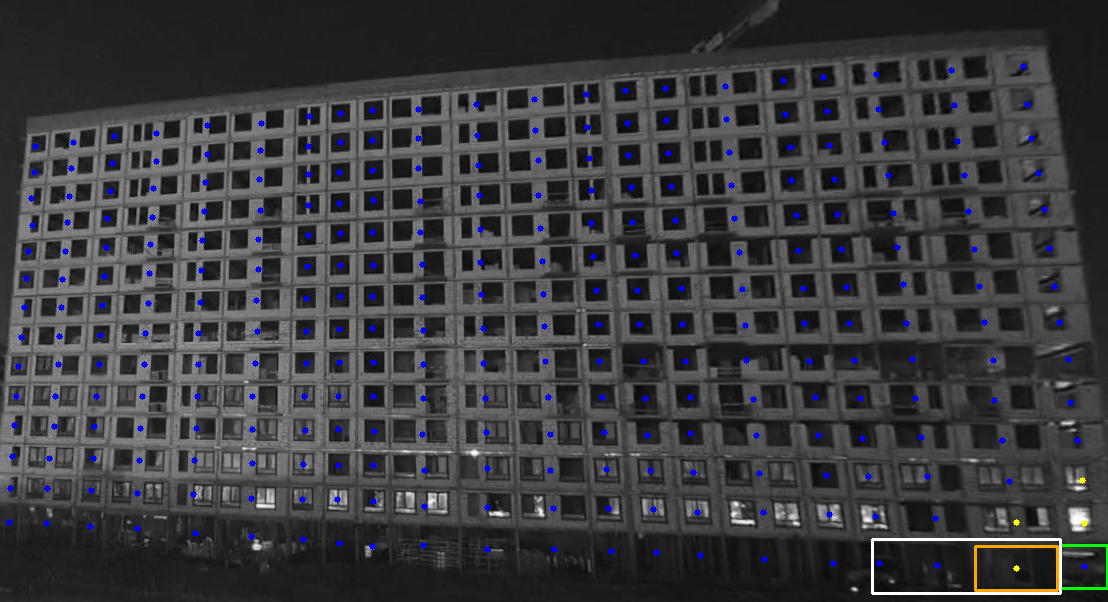

In [64]:

def get_size(point):
    return int(point[2]), int(point[3])

target_image_name = image_path
annotations_for_image = get_annotations(target_image_name)

image = IMG.copy()

points = list(annotations_for_image.keys())
for point in points:
    center = (int(point[0]), int(point[1]))
    cv2.circle(image, center, 3, (255, 0, 0), -1)

highest_point = max(points, key=lambda p: (p[0]+p[1]))
point_size = get_size(annotations_for_image[highest_point])

cv2.rectangle(image, (int(highest_point[0] - point_size[0]/2), int(highest_point[1] - point_size[1]/2)),
              (int(highest_point[0] + point_size[0]/2), int(highest_point[1] + point_size[1]/2)),
              (0, 255, 0), 2)

def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

def get_n_nearest_neighbors(point, all_points, n):
    distances = [(p, euclidean_distance(point, p)) for p in all_points if p != point]
    distances.sort(key=lambda x: x[1])
    return distances[:n]

n_neighbors = 4
neighbors = get_n_nearest_neighbors(highest_point, points, n_neighbors)

for neighbor in neighbors:
    cv2.circle(image, (int(neighbor[0][0]), int(neighbor[0][1])), 3, (0, 255, 255), -1)

additional_rect_width = int(point_size[0] * 4)
additional_rect_height = int(point_size[1]*1.3)

y_middle = int(highest_point[1])

additional_rect_top_left = (int(highest_point[0] - point_size[0]/2 - additional_rect_width),
                            y_middle - additional_rect_height//2)
additional_rect_bottom_right = (int(highest_point[0] - point_size[0]/2),
                                y_middle + additional_rect_height//2)

cv2.rectangle(image, additional_rect_top_left, additional_rect_bottom_right, (255, 255, 255), 2)


for neighbor in neighbors:
    if (additional_rect_top_left[0] < neighbor[0][0] < additional_rect_bottom_right[0] and
        additional_rect_top_left[1] < neighbor[0][1] < additional_rect_bottom_right[1]):

        neighbor_size = get_size(annotations_for_image[neighbor[0]])

        orange_rect_top_left = (int(neighbor[0][0] - neighbor_size[0] / 2),
                                int(neighbor[0][1] - neighbor_size[1] / 2))
        orange_rect_bottom_right = (int(neighbor[0][0] + neighbor_size[0] / 2),
                                    int(neighbor[0][1] + neighbor_size[1] / 2))

        cv2.rectangle(image, orange_rect_top_left, orange_rect_bottom_right, (0, 165, 255), 2)


cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()
